# Stock Price Analystics with Alpha Vantage

In [26]:
!pip install requests pandas matplotlib pandas-market-calendars

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.3/107.3 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.1/196.1 kB 5.5 MB/s eta 0:00:00


In [27]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import os
from dotenv import load_dotenv
from datetime import datetime, timedelta
import pandas_market_calendars as mcal


In [8]:
# Load environment variables from .env file
load_dotenv()
# Read the API key from environment variable
api_key = os.getenv('ALPHA_VANTAGE_API_KEY')

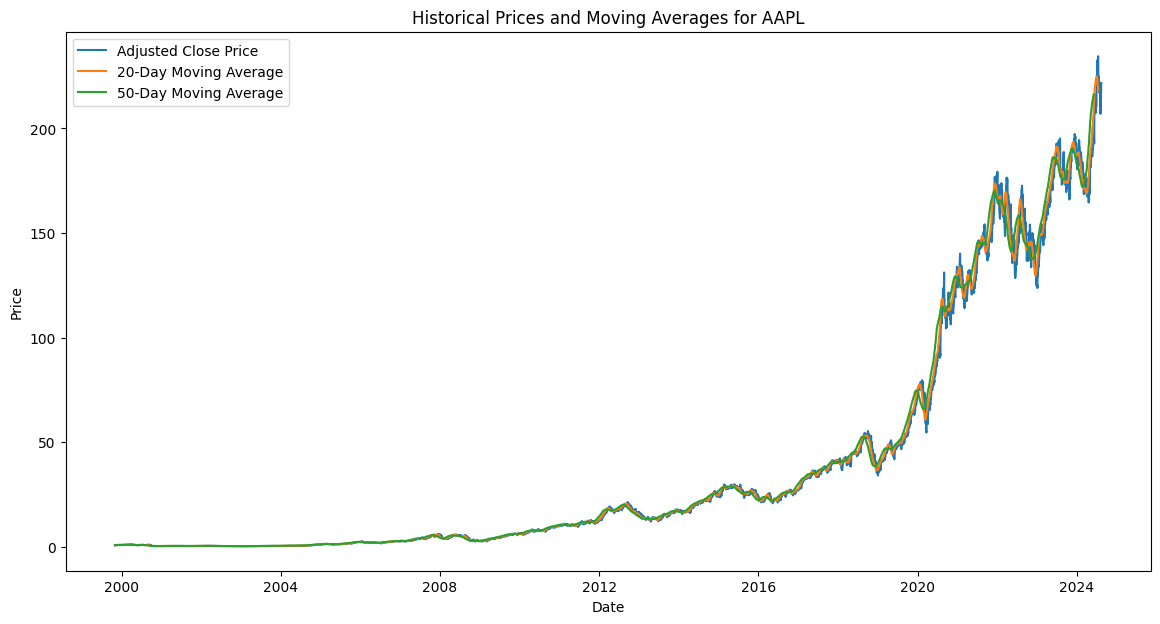

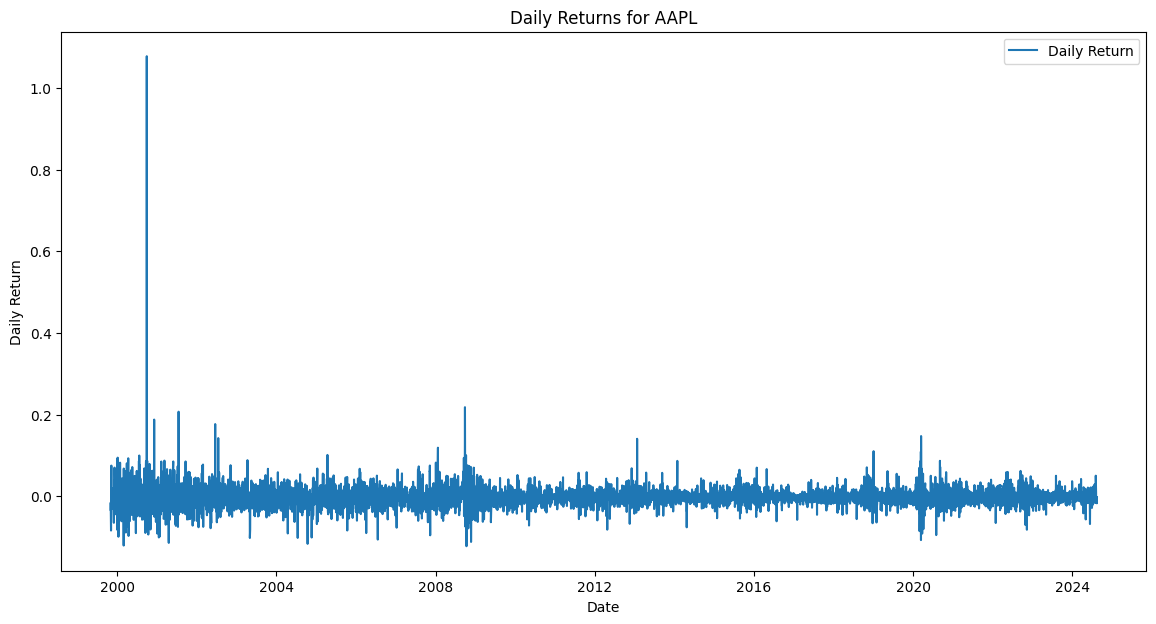

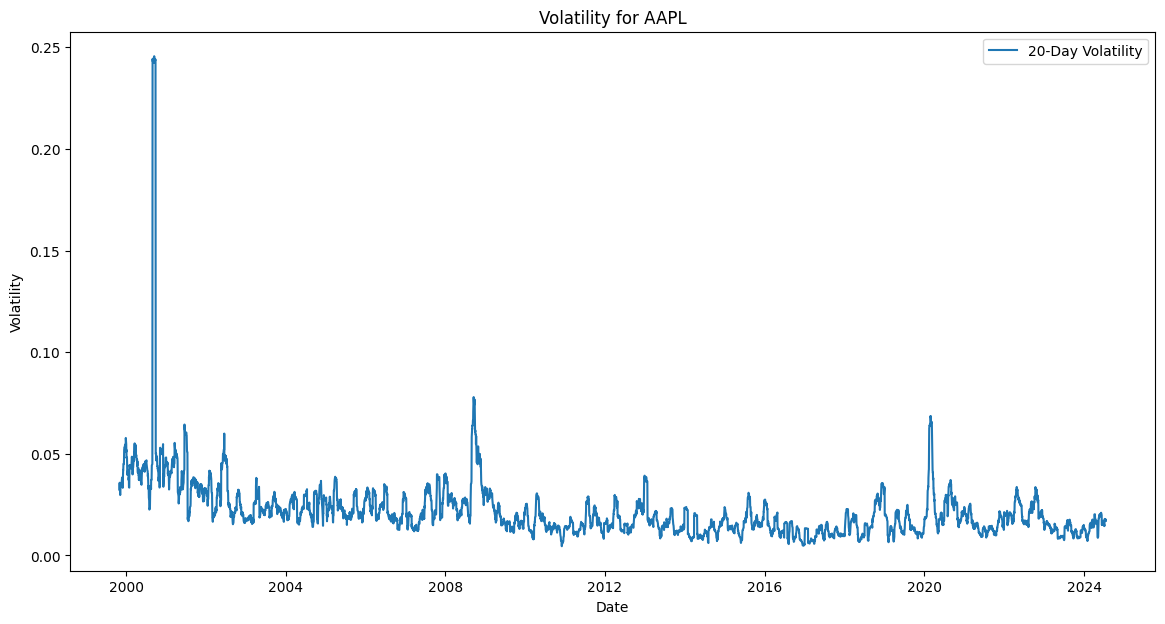

In [4]:
# Function to fetch historical daily price data
def fetch_historical_data(symbol, api_key, outputsize='compact'):
    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={symbol}&outputsize={outputsize}&apikey={api_key}'
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        time_series = data['Time Series (Daily)']
        df = pd.DataFrame.from_dict(time_series, orient='index')
        df = df.astype(float)
        df.index = pd.to_datetime(df.index)
        df.columns = ['open', 'high', 'low', 'close', 'adjusted_close', 'volume', 'dividend_amount', 'split_coefficient']
        return df
    else:
        print(f"Failed to fetch data for {symbol}. Status code: {response.status_code}")
        return None

# Example usage
symbol = 'AAPL'
data = fetch_historical_data(symbol, api_key, outputsize='full')

# Calculate Moving Averages
data['MA20'] = data['adjusted_close'].rolling(window=20).mean()
data['MA50'] = data['adjusted_close'].rolling(window=50).mean()

# Calculate Daily Returns
data['Daily Return'] = data['adjusted_close'].pct_change()

# Calculate Volatility (Rolling Standard Deviation)
data['Volatility'] = data['Daily Return'].rolling(window=20).std()

In [56]:
import pandas as pd
from datetime import datetime, timedelta
import requests
import pandas_market_calendars as mcal
import pytz
from dotenv import load_dotenv
import os

# Load environment variables from .env file
load_dotenv()

# Read the API key from environment variable
api_key = os.getenv('ALPHA_VANTAGE_API_KEY')

def fetch_historical_data(symbol, api_key, outputsize='full'):
    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={symbol}&outputsize={outputsize}&apikey={api_key}'
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        time_series = data['Time Series (Daily)']
        df = pd.DataFrame.from_dict(time_series, orient='index')
        df = df.astype(float)
        df.index = pd.to_datetime(df.index)
        df.columns = ['open', 'high', 'low', 'close', 'adjusted_close', 'volume', 'dividend_amount', 'split_coefficient']
        return df
    else:
        print(f"Failed to fetch data for {symbol}. Status code: {response.status_code}")
        return None

# Initialize NYSE calendar
nyse = mcal.get_calendar('NYSE')

# Corrected get_last_trading_day function
def get_last_trading_day(date, data):
    """Get the last trading day on or before the given date."""
    trading_days = data.index  # Use the index of the DataFrame, which contains the trading days
    trading_days = trading_days.sort_values()

    # Filter for days before or equal to the specified date
    past_trading_days = trading_days[trading_days <= date]
    
    if not past_trading_days.empty:
        return past_trading_days[-1]
    else:
        raise ValueError(f"No trading day found on or before {date}.")

def calculate_performance(data, actual_date):
    """ Calculate the performance for today, 5-day, 1-month, 6-month, 1-year. """
    performances = {}

    # Get the last trading day for the actual date provided
    today = get_last_trading_day(actual_date, data)

    if today not in data.index:
        raise ValueError(f"The date {today.date()} is not in the data. Ensure your data covers the required date range.")

    today_price = data.loc[today]['close']

    # Calculate today's performance
    performances['Today'] = (data.loc[today]['close'] - data.loc[today]['open']) / data.loc[today]['open'] * 100

    # Calculate 5-day, 1-month, 6-month, and 1-year performance
    for days_back, label in [(5, '5-Day'), (21, '1-Month'), (126, '6-Month'), (252, '1-Year')]:
        past_day = get_last_trading_day(today - timedelta(days=days_back), data)
        if past_day in data.index:
            past_price = data.loc[past_day]['close']
            performance = (today_price - past_price) / past_price * 100
            performances[label] = performance
        else:
            performances[label] = None  # Handle missing data gracefully

    # Format the performance as percentages with one decimal point
    formatted_performances = {key: f"{value:.1f}%" if value is not None else "N/A" for key, value in performances.items()}
    
    return formatted_performances

# Example usage
today = datetime.now()
stocks = ['AAPL']
for symbol in stocks:
    data = fetch_historical_data(symbol, api_key, outputsize='full')
    if data is not None:
        performances = calculate_performance(data, today)
        print(f"{symbol}: {performances}")

AAPL: {'Today': '0.5%', '5-Day': '2.5%', '1-Month': '1.5%', '6-Month': '32.1%', '1-Year': '15.3%'}


In [57]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta

# Define the stock symbols and the time periods
stock_symbols = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']
time_periods = {
    'today': 1,
    'last_5_days': 5,
    'last_month': 30,
    'last_6_months': 180,
    'last_1_year': 365,
    'last_2_years': 730,
    'last_3_years': 1095,
    'last_4_years': 1460,
    'last_5_years': 1825
}

# Fetch historical data for each stock
def fetch_stock_data(symbols, period):
    end_date = datetime.now()
    start_date = end_date - timedelta(days=period)
    data = yf.download(symbols, start=start_date, end=end_date)
    return data['Adj Close']

# Fetch data for all time periods
stock_data = {period: fetch_stock_data(stock_symbols, days) for period, days in time_periods.items()}

[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  5 of 5 completed


In [58]:
def calculate_performance(data):
    performance = {}
    for period, df in data.items():
        performance[period] = (df.iloc[-1] / df.iloc[0] - 1) * 100
    return performance

stock_performance = calculate_performance(stock_data)

In [59]:
import plotly.graph_objects as go

# Function to create a bar chart for stock performance
def plot_stock_performance(stock_performance, stock_symbols):
    fig = go.Figure()
    for stock in stock_symbols:
        fig.add_trace(go.Bar(
            x=list(stock_performance.keys()),
            y=[stock_performance[period][stock] for period in stock_performance],
            name=stock
        ))
    fig.update_layout(
        title='Stock Performance Over Different Time Periods',
        xaxis_title='Time Period',
        yaxis_title='Performance (%)',
        barmode='group'
    )
    fig.show()

# Plot the stock performance
plot_stock_performance(stock_performance, stock_symbols)

In [90]:
import yfinance as yf
import pandas as pd
from datetime import datetime
import pandas_market_calendars as mcal

# Print today's date
today_date = datetime.now().strftime("%Y-%m-%d")
print(f"Today's Date: {today_date}")

# Define the stock symbols and the time periods (in months)
stock_symbols = ['AAPL', 'MSFT']
time_periods = {
    'today': 0,  # 0 means today
    'last_5_days': 5 / 30,  # Approximate days as fractions of a month
    'last_month': 1,
    'last_6_months': 6,
    'last_1_year': 12,
    'last_2_years': 24,
    'last_3_years': 36,
    'last_4_years': 48,
    'last_5_years': 60
}

# Fetch historical data for each stock
def fetch_stock_data(symbol, months_back):
    end_date = datetime.now()
    
    # Calculate start date by subtracting the number of months from the current date
    start_date = end_date - pd.DateOffset(months=months_back)
    
    # Ensure that start_date and end_date are valid trading days
    nyse = mcal.get_calendar('NYSE')
    trading_days = nyse.valid_days(start_date=start_date, end_date=end_date)
    
    # Adjust start_date to the closest valid trading day if necessary
    if not trading_days.empty:
        start_date = trading_days[0]
    else:
        print(f"No valid trading days found between {start_date} and {end_date} for {symbol}.")
        return None
    
    data = yf.download(symbol, start=start_date, end=end_date)
    
    # Print the start and end dates used for data fetching
    print(f"Data for {symbol} - {months_back} months:")
    print(f"  Start Date: {start_date.strftime('%Y-%m-%d')}")
    print(f"  End Date: {end_date.strftime('%Y-%m-%d')}")

    return data[['Open', 'Adj Close']]

# Fetch current price for a stock
def fetch_current_price(symbol):
    ticker = yf.Ticker(symbol)
    todays_data = ticker.history(period='1d')
    return todays_data['Close'][0]

# Fetch data for all time periods for each stock
stock_data = {symbol: {period: fetch_stock_data(symbol, months) for period, months in time_periods.items()} for symbol in stock_symbols}

# Calculate the performance of each stock over the specified time periods
def calculate_performance(data):
    performance = {}
    for symbol, periods in data.items():
        performance[symbol] = {}
        for period, df in periods.items():
            if df is not None and not df.empty:
                if period == 'today':
                    ticker = yf.Ticker(symbol)
                    todays_data = ticker.history(period='1d')
                    open_price = todays_data['Open'].iloc[0]
                    current_price = todays_data['Close'].iloc[-1]

                    # Print today's open and close prices
                    print(f"{symbol} - {period.capitalize()}:")
                    print(f"  Open Price: {open_price}")
                    print(f"  Close Price: {current_price}")

                    performance[symbol][period] = ((current_price / open_price) - 1) * 100
                else:
                    # Print the open and close prices for the period
                    print(f"{symbol} - {period.capitalize()}:")
                    print(f"  Open Price: {df['Open'].iloc[0]}")
                    print(f"  Close Price: {df['Adj Close'].iloc[-1]}")

                    performance[symbol][period] = (df['Adj Close'].iloc[-1] / df['Adj Close'].iloc[0] - 1) * 100
            else:
                performance[symbol][period] = "N/A"

    return performance

# Add a print statement to verify cell execution
print("Executing stock performance calculation...")

stock_performance = calculate_performance(stock_data)

# Create a DataFrame to display the performance
performance_df = pd.DataFrame(stock_performance).T
performance_df = performance_df.round(1)  # Round to 1 decimal place

# Format the DataFrame to include the % sign
performance_df = performance_df.applymap(lambda x: f"{x:.1f}%" if isinstance(x, (int, float)) else x)

# Display the DataFrame
performance_df

Today's Date: 2024-08-14


[*********************100%%**********************]  1 of 1 completed

Data for AAPL - 0 months:
  Start Date: 2024-08-14
  End Date: 2024-08-14


ValueError: Non-integer years and months are ambiguous and not currently supported.